<a href="https://colab.research.google.com/github/Shreeshambav/DeepLearning_training/blob/main/Deeplearning_SARIMA_Budgeting_and_Forecasting_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Budget_merged_file_Cat_with_outliers_MRL_LINE_replaced.xlsx to Budget_merged_file_Cat_with_outliers_MRL_LINE_replaced.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Import SARIMAX for SARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf  # Add 'acf' and 'pacf' to the import statement
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import os


# Read the data
# file_path_merged = 'E:\\Raj\\Book-working\\10-Python\\Program\\Alpha_Optimum_Python\\Projects\\DS\\DL\\Sunoida\\Working_data\\Budget_merged_file_Cat_with_outliers_MRL_LINE_replaced.xlsx'
# df = pd.read_excel(file_path_merged)
file_path = 'Budget_merged_file_Cat_with_outliers_MRL_LINE_replaced.xlsx'
df = pd.read_excel(file_path)
# Drop rows with missing values in the specified columns
df = df.dropna(subset=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])

# Convert the values in columns "01" to "12" to numeric
df[["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]] = df[["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]].apply(pd.to_numeric, errors="coerce")

# Calculate the sum of values for each row
df["Sum"] = df[["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]].sum(axis=1)

# Filter rows where the sum of values is greater than 0
filtered_data = df[df["Sum"] > 0]

# Group the data by "COUNTRY" and "Year" and calculate the mean of the sum for each group
grouped_data = filtered_data.groupby(["COUNTRY", "Year"])["Sum"].mean()

print(grouped_data)

# # Group the data based on 'MRL_Category'
# grouped_df = df.groupby('MRL_Category')


# Group the data based on the new 'MRL_Category' columns
grouped_df = df.groupby(['MRL_Category_Cat1', 'MRL_Category_Cat2', 'MRL_Category_Cat3', 'MRL_Category_Cat4'])

# Helper function to create a concatenated MRL category string
def get_category_string(row):
    return f"{row['MRL_Category_Cat1']}_{row['MRL_Category_Cat2']}_{row['MRL_Category_Cat3']}_{row['MRL_Category_Cat4']}"

# Define ARIMA model parameters
# order = (5, 1, 0)  # (p, d, q) - ARIMA parameters

# Create an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=["Category", "Year", "Month", "ARIMA_Prediction", "SARIMA_Prediction", "ETS_Prediction", "Forecast_Trend_Arima", "Forecast_Trend_Sarima"])

# Create an empty DataFrame to store the forecast for year 2022
forecast_df = pd.DataFrame(columns=["Category", "Year", "Month", "Forecast_Arima", "Forecast_Sarima", "Forecast_Arima_e", "Forecast_Sarima_e"])


# Create empty lists to store statistics for ARIMA and Exponential Smoothing separately
arima_stats_list = []
ets_stats_list = []
sarima_stats_list = []

# Filter data for each year (2019, 2020, 2021) and apply ARIMA model for each category
years = [2019, 2020, 2021, 2022]
months = ["{:02d}".format(month) for month in range(1, 13)]

# Helper function to find the last financial year
def find_last_financial_year(years):
    sorted_years = sorted(years, reverse=True)
    for i in range(len(sorted_years) - 1):
        if sorted_years[i] - 1 != sorted_years[i + 1]:
            return sorted_years[i]
    return sorted_years[-1]


##########################################
# # Helper function to calculate the forecast trend
# def calculate_forecast_trend(train_data, arima_predictions):
#     # Calculate the cumulative sum of ARIMA predictions
#     forecast_trend_arima = train_data[-1] + np.cumsum(arima_predictions)
#     return forecast_trend_arima

# def calculate_forecast_trend1(train_data, sarima_predictions):
#     # Calculate the cumulative sum of ARIMA predictions
#     forecast_trend_sarima = train_data[-1] + np.cumsum(sarima_predictions)
#     return forecast_trend_sarima
#############################################


for category, group_df in grouped_df:
    for year in years:
        year_df = group_df[group_df['Year'] == year]

        # Check if all 12 columns exist in the DataFrame
        data_columns = [str(month).zfill(2) for month in range(1, 13)]
        missing_columns = [col for col in data_columns if col not in year_df.columns]

        if missing_columns:
            print(f"Missing data columns for Category: {category}, Year: {year}: {missing_columns}")
            continue

        data = year_df[data_columns].values.flatten()

        # Handle cases where there might be missing data for some years
        if np.any((data != 0) & pd.notnull(data)):
            # Find last financial year
            last_financial_year = find_last_financial_year(years)

            # Split data into train and test sets
            if year == last_financial_year:
                # Last 12 months as test data
                train_data = data[:-12]
                test_data = data[-12:]
            else:
                # Rest as train data
                train_data = data[:-12]  # Use all available data except the last 12 months
                test_data = data[-12:]  # Use the last 12 months as test data

            # Perform ADF test to check for stationarity
            adf_result = adfuller(train_data)
            p_value = adf_result[1]
            is_stationary = p_value < 0.05
            print(f"Category: {category}, Year: {year} - Time series is Stationary.")

            if not is_stationary:
                print(f"Category: {category}, Year: {year} - Time series is non-stationary.")
                continue

            # Try different ARIMA model orders and methods
            orders_to_try = [(5, 1, 0), (5, 1, 1), (5, 1, 2)]  # Add more orders to try

            model_fit = None
            converged = False
            for order in orders_to_try:
                try:
                    # Try fitting ARIMA model using different orders
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")  # Ignore ConvergenceWarning
                        model = ARIMA(train_data, order=order)
                        model_fit = model.fit()
                        arima_predictions = model_fit.forecast(steps=12)
                    converged = True
                    break  # Break if the model successfully converges
                except Exception as e:
                    print(f"ARIMA model did not converge for Category: {category}, Year: {year}, Order: {order}")
                    print(f"Error message: {str(e)}")
                    continue

            if not converged:
                print(f"ARIMA model did not converge for any combination of orders for Category: {category}, Year: {year}.")
                continue

            # Flatten the arima_predictions to match the shape of test_data
            arima_predictions = arima_predictions.flatten()

            # Fit exponential smoothing model and make predictions for the out-of-sample period (2022)
            ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12)
            ets_fit = ets_model.fit()
            ets_predictions = ets_fit.forecast(steps=12)
            # Flatten the ets_predictions to match the shape of test_data
            ets_predictions = ets_predictions.flatten()

            # Fit SARIMA model and make predictions for the out-of-sample period (2022)
            sarima_model = SARIMAX(train_data, order=order, seasonal_order=(0, 1, 1, 12))
            sarima_fit = sarima_model.fit()
            sarima_predictions = sarima_fit.forecast(steps=12)
            # Flatten the sarima_predictions to match the shape of test_data
            sarima_predictions = sarima_predictions.flatten()
########
            # ACF and PACF with upper and lower bound

            # Calculate ACF and PACF for the training data
            acf_values, confint_acf = acf(train_data, nlags=30, alpha=0.05)
            pacf_values, confint_pacf = pacf(train_data, nlags=30, alpha=0.05)

            # Plot the ACF and PACF with upper and lower bounds
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 1, 1)
            plt.title("Autocorrelation Function (ACF)")
            plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
            plt.axhline(y=-1.96/np.sqrt(len(train_data)), linestyle='--', color='gray')  # Lower bound
            plt.axhline(y=1.96/np.sqrt(len(train_data)), linestyle='--', color='gray')   # Upper bound
            plt.grid(True)

            plt.subplot(2, 1, 2)
            plt.title("Partial Autocorrelation Function (PACF)")
            plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
            plt.axhline(y=-1.96/np.sqrt(len(train_data)), linestyle='--', color='gray')  # Lower bound
            plt.axhline(y=1.96/np.sqrt(len(train_data)), linestyle='--', color='gray')   # Upper bound
            plt.grid(True)

            plt.tight_layout()
            plt.show()
#####
            # Calculate Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE)
            if np.any(test_data):
                mse_arima = mean_squared_error(test_data.reshape(-1, 1), arima_predictions.reshape(-1, 1))
                rmse_arima = np.sqrt(mse_arima)
                z_scores_test_arima = (test_data - np.mean(test_data)) / np.std(test_data)
                z_scores_pred_arima = (arima_predictions - np.mean(arima_predictions)) / np.std(arima_predictions)

                # Calculate MAPE only for non-zero elements in test_data
                non_zero_indices_arima = test_data != 0
                mape_arima = np.mean(np.abs((test_data[non_zero_indices_arima] - arima_predictions[non_zero_indices_arima]) / test_data[non_zero_indices_arima])) * 100

                print("ARIMA - MSE:", mse_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)

                mse_ets = mean_squared_error(test_data.reshape(-1, 1), ets_predictions.reshape(-1, 1))
                rmse_ets = np.sqrt(mse_ets)
                z_scores_test_ets = (test_data - np.mean(test_data)) / np.std(test_data)
                z_scores_pred_ets = (ets_predictions - np.mean(ets_predictions)) / np.std(ets_predictions)

                # Calculate MAPE only for non-zero elements in test_data
                non_zero_indices_ets = test_data != 0
                mape_ets = np.mean(np.abs((test_data[non_zero_indices_ets] - ets_predictions[non_zero_indices_ets]) / test_data[non_zero_indices_ets])) * 100

                print("Exponential Smoothing - MSE:", mse_ets, "RMSE:", rmse_ets, "MAPE:", mape_ets)

                mse_sarima = mean_squared_error(test_data.reshape(-1, 1), sarima_predictions.reshape(-1, 1))
                rmse_sarima = np.sqrt(mse_sarima)
                z_scores_test_sarima = (test_data - np.mean(test_data)) / np.std(test_data)
                z_scores_pred_sarima = (sarima_predictions - np.mean(sarima_predictions)) / np.std(sarima_predictions)

                # Calculate MAPE only for non-zero elements in test_data
                non_zero_indices_sarima = test_data != 0
                mape_sarima = np.mean(np.abs((test_data[non_zero_indices_sarima] - sarima_predictions[non_zero_indices_sarima]) / test_data[non_zero_indices_sarima])) * 100

                print("SARIMA - MSE:", mse_sarima, "RMSE:", rmse_sarima, "MAPE:", mape_sarima, "Z_score:", z_scores_test_sarima, "Z_scores:", z_scores_pred_sarima)

            else:
                print(f"No test data available for Category: {category}, Year: {year}")

            # Append the statistics values to the appropriate lists
            arima_stats_list.append({"Category": category, "Year": year, "Model": "ARIMA", "MSE": mse_arima, "RMSE": rmse_arima, "MAPE": mape_arima, "z_scores_t": z_scores_test_arima, "z_scores_p": z_scores_pred_arima})
            ets_stats_list.append({"Category": category, "Year": year, "Model": "Exponential Smoothing", "MSE": mse_ets, "RMSE": rmse_ets, "MAPE": mape_ets, "z_scores_t": z_scores_test_ets, "z_scores_p": z_scores_pred_ets})
            sarima_stats_list.append({"Category": category, "Year": year, "Model": "SARIMA", "MSE": mse_sarima, "RMSE": rmse_sarima, "MAPE": mape_sarima, "z_scores_t": z_scores_test_sarima, "z_scores_p": z_scores_pred_sarima})
########


            # Append the predictions and forecast trend to the DataFrame
            forecast_trend_arima = np.append(train_data[-1], arima_predictions.cumsum())
            forecast_trend_sarima = np.append(train_data[-1], sarima_predictions.cumsum())

            prediction_data = []
            for month, arima_pred, sarima_pred, ets_pred, trend_value_arima, trend_value_sarima in zip(months[-12:], arima_predictions, sarima_predictions, ets_predictions, forecast_trend_arima[-12:], forecast_trend_sarima[-12:]):
                prediction_data.append({"Category": category, "Year": year, "Month": month, "ARIMA_Prediction":arima_pred, "SARIMA_Prediction":sarima_pred,"Forecast_Trend_Arima": trend_value_arima, "Forecast_Trend_Sarima": trend_value_sarima, "ETS_Prediction": ets_pred})

            predictions_df = pd.concat([predictions_df, pd.DataFrame(prediction_data)], ignore_index=True)



            # Append the forecast for year 2022 to the forecast DataFrame
            forecast_data = []
            for month, trend_value_arima, trend_value_sarima, ets_pred in zip(months, forecast_trend_arima, forecast_trend_sarima, ets_predictions):
                forecast_data.append({"Category": category, "Year": 2022, "Month": month, "Forecast_Arima": trend_value_arima, "Forecast_Sarima": trend_value_sarima,"Forecast_Arima_e": (trend_value_arima + ets_pred), "Forecast_Sarima_e": (trend_value_sarima + ets_pred)})

            forecast_df = pd.concat([forecast_df, pd.DataFrame(forecast_data)], ignore_index=True)




########

            # Plot the actual data and predictions
            plt.figure(figsize=(12, 8))
            # Create a time range spanning from the beginning of the train data to the end of the prediction period (2022)
            # time_range = np.arange(1, len(train_data) + len(arima_predictions) + 1)
            time_range = np.arange(1, len(train_data) + len(test_data) + 1)


            # Plot actual data
            plt.plot(time_range[:len(train_data)], train_data, label="Train Data")
            plt.plot(time_range[-12:], test_data, label="Test Data")

            # Plot ARIMA predictions
            pred_time_range = np.arange(len(train_data), len(train_data) + len(arima_predictions))
            plt.plot(pred_time_range, arima_predictions, label="ARIMA Predictions")

            # Plot exponential smoothing predictions
            plt.plot(pred_time_range, ets_predictions, label="Exponential Smoothing Predictions")

            # Plot the trend of the forecast for 2022 - Arima (prediction)
            forecast_time_range = np.arange(len(train_data), len(train_data) + len(arima_predictions) + 1)
            plt.plot(forecast_time_range, forecast_trend_arima, label="Forecast Trend - ARIMA", linestyle="--")

            # Plot the trend of the forecast for 2022 - Sarima (prediction)
            forecast_time_range = np.arange(len(train_data), len(train_data) + len(arima_predictions) + 1)
            plt.plot(forecast_time_range, forecast_trend_sarima, label="Forecast Trend - SARIMA", linestyle="--")

            plt.xlabel("Months")
            plt.ylabel("Values")
            plt.title(f"Category: {category}, Year: {year}")
            plt.legend(loc="upper left")  # Adjust the legend position
            plt.grid(True)  # Add gridlines to the plot
            # plt.xticks(time_range, months + [f"2022-{m}" for m in months], rotation=45)  # Update x-axis ticks with actual months
            plt.tight_layout()  # Adjust plot layout

            # Generate a unique file name for each plot
            file_name = f"Category_{category}_{year}"
            path = 'E:\\Raj\\Book-working\\10-Python\\Program\\Alpha_Optimum_Python\\Projects\\DS\\DL\\Sunoida\\Sarima\\Sarimaplots\\Category'

            # Join the file_name to the path
            full_path = os.path.join(path, file_name)
            # Save the plot to a file
            # plt.savefig(full_path)

            plt.show()

# Create DataFrames from the lists of statistics
arima_stats_df = pd.DataFrame(arima_stats_list)
ets_stats_df = pd.DataFrame(ets_stats_list)
sarima_stats_df = pd.DataFrame(sarima_stats_list)  # Add SARIMA stats DataFrame

# Concatenate SARIMA, ARIMA and Exponential Smoothing statistics DataFrames
stats_df = pd.concat([arima_stats_df, ets_stats_df, sarima_stats_df], ignore_index=True)

# Save the pred_output_file DataFrame to an Excel file
pred_output_file = 'E:\\Raj\\Book-working\\10-Python\\Program\\Alpha_Optimum_Python\\Projects\\DS\\DL\\Sunoida\\Sarima\\Budget_merged_file_Cat_predicted_Sarima_Category.xlsx'
predictions_df.to_excel(pred_output_file, index=False)

# Save the statistics DataFrame to an Excel file
stats_output_file = 'E:\\Raj\\Book-working\\10-Python\\Program\\Alpha_Optimum_Python\\Projects\\DS\\DL\\Sunoida\\Sarima\\Budget_merged_file_Cat_predicted_Stats_Sarima_Category.xlsx'
stats_df.to_excel(stats_output_file, index=False)

# Save the forecast DataFrame to an Excel file
forecast_output_file = 'E:\\Raj\\Book-working\\10-Python\\Program\\Alpha_Optimum_Python\\Projects\\DS\\DL\\Sunoida\\Sarima\\Budget_merged_file_Cat_forecast_Sarima_Category.xlsx'
forecast_df.to_excel(forecast_output_file, index=False)











NameError: ignored

COUNTRY  Year
KE       2019    2.957113e+06
         2020    3.090709e+06
         2021    2.864821e+06
Name: Sum, dtype: float64
Category: (0, 0, 0, 0), Year: 2019 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


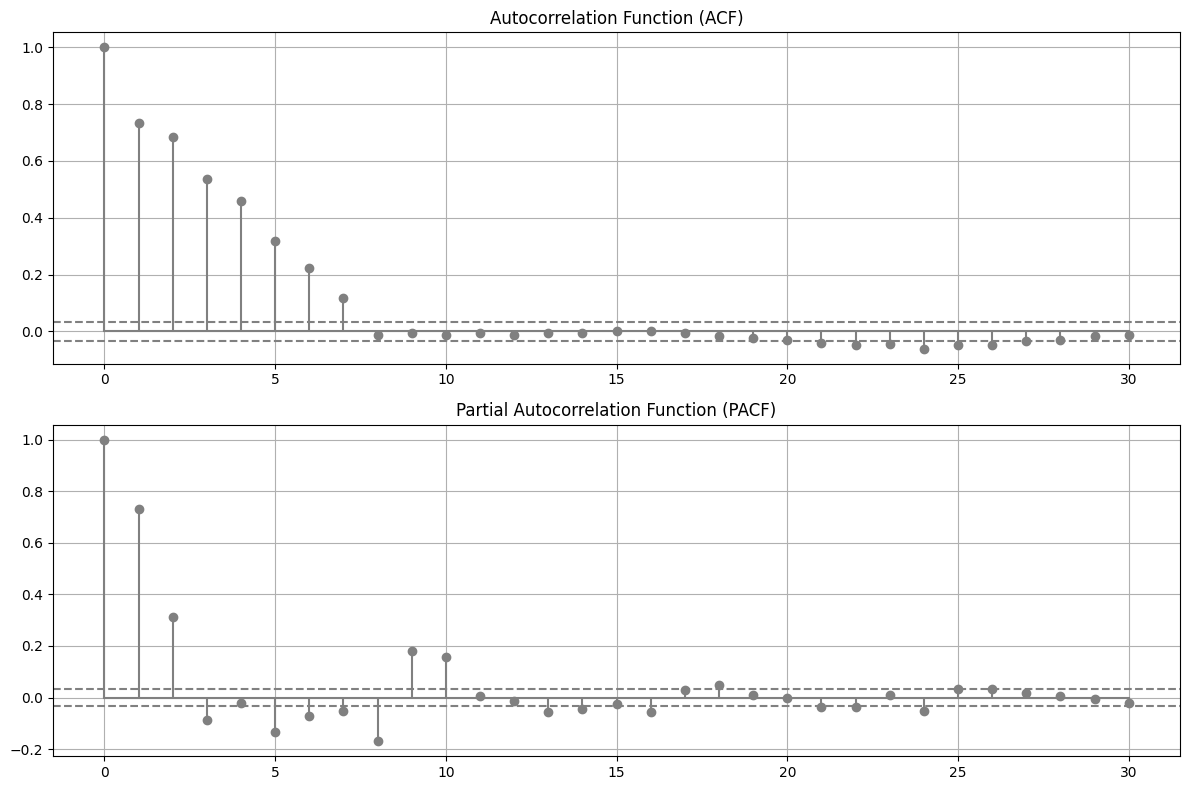

ARIMA - MSE: 2918691.1549387593 RMSE: 1708.4177343199055 MAPE: 62.76502540509345
Exponential Smoothing - MSE: 663994069.8443804 RMSE: 25768.08238585829 MAPE: 687.2109134986729
SARIMA - MSE: 452035304.2677307 RMSE: 21261.121895792112 MAPE: 1375.479386169754


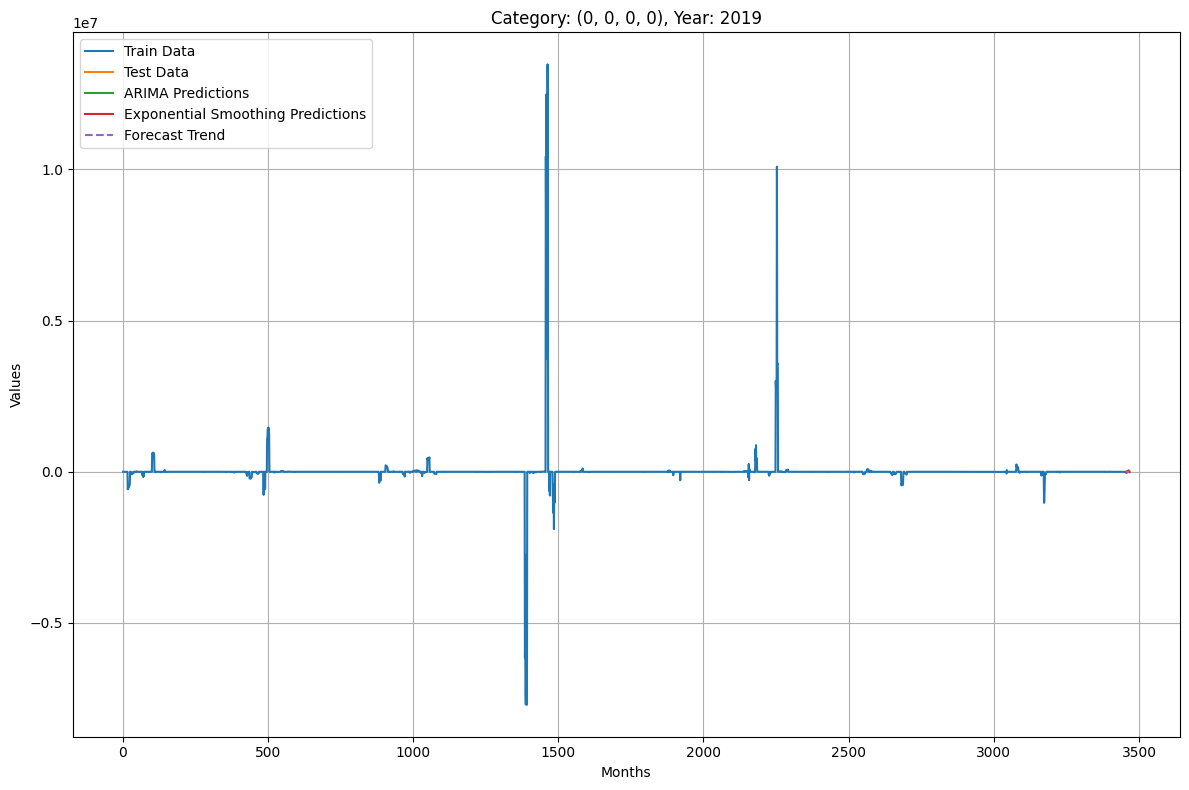

Category: (0, 0, 0, 0), Year: 2020 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


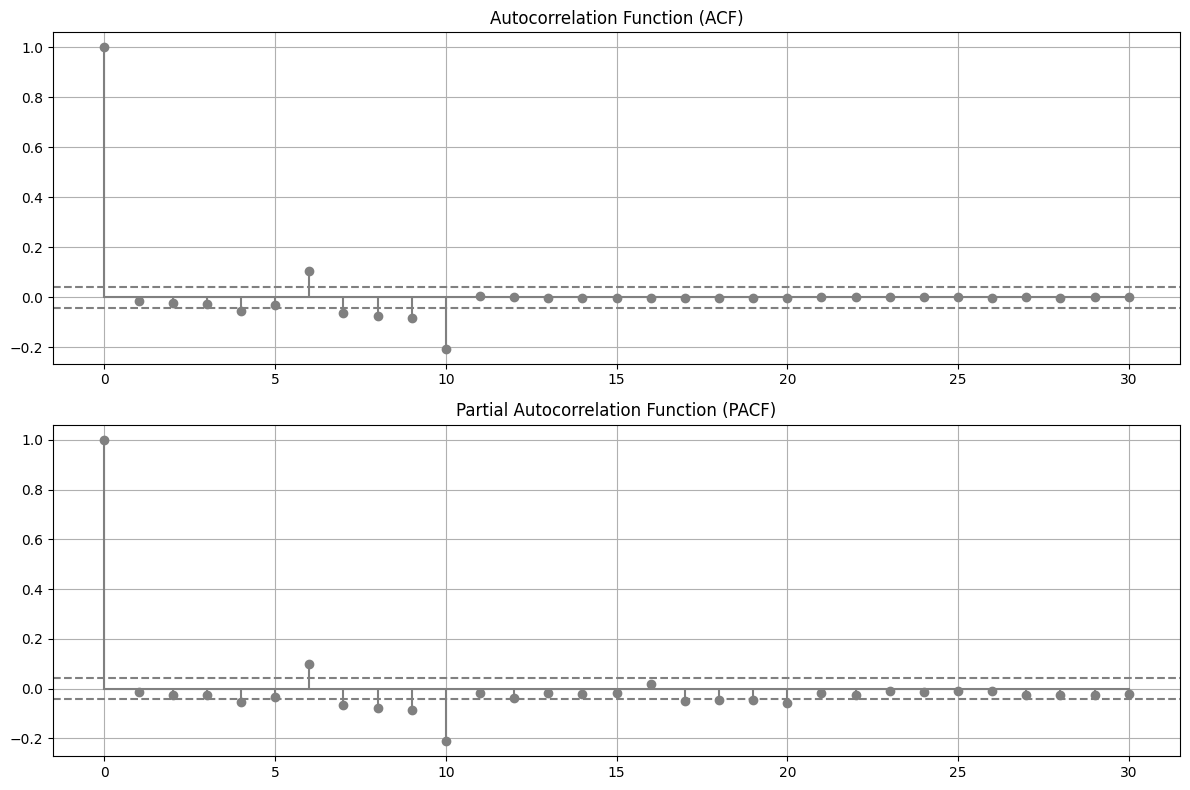

ARIMA - MSE: 165727.89545494923 RMSE: 407.0969116254129 MAPE: 100.0
Exponential Smoothing - MSE: 5548128760.6664 RMSE: 74485.76213388972 MAPE: 4877.311505025821
SARIMA - MSE: 2664325542.944511 RMSE: 51617.10513913495 MAPE: 4848.910997293547


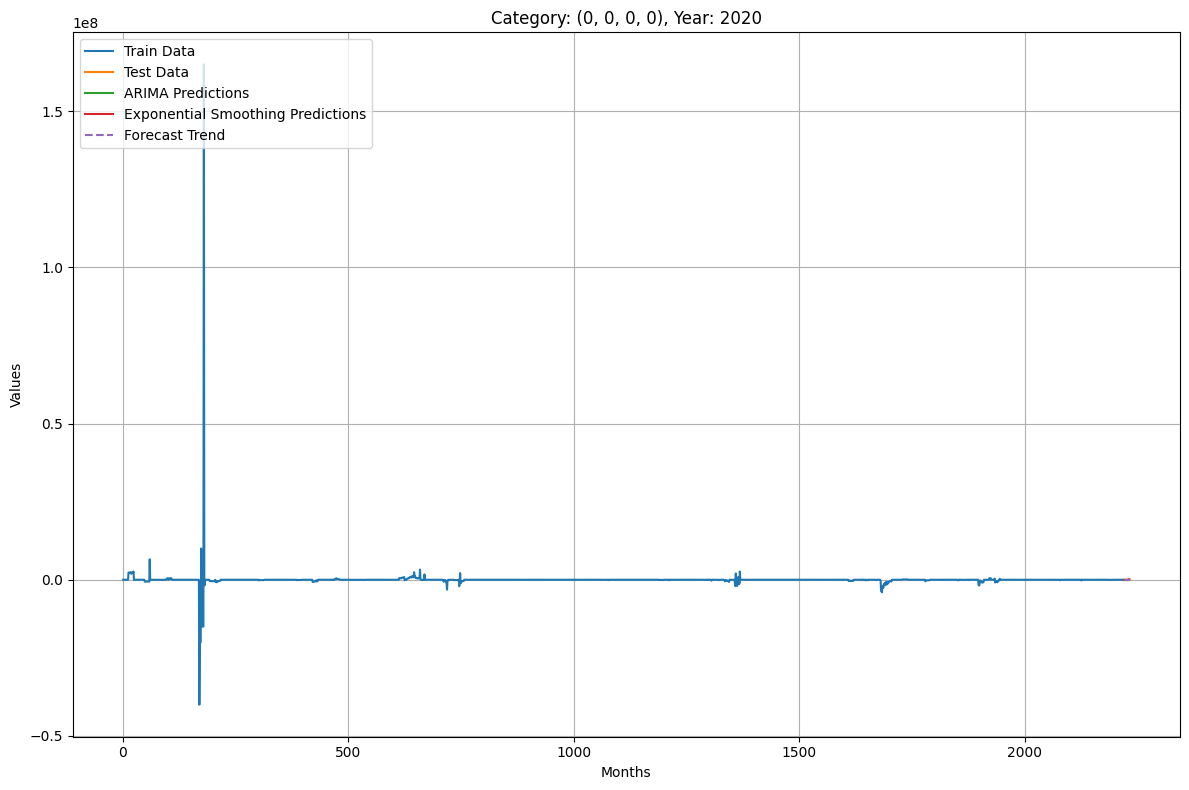

Category: (0, 0, 0, 0), Year: 2021 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


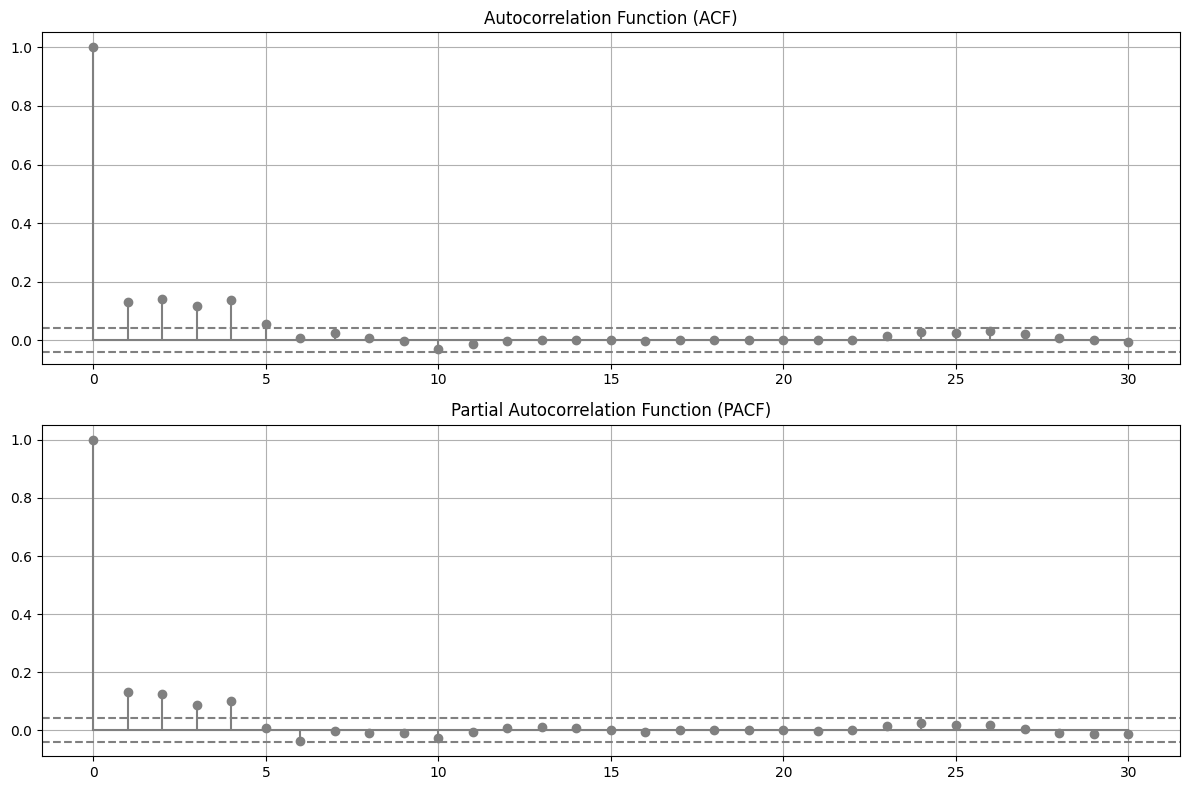

ARIMA - MSE: 646949827542.3118 RMSE: 804331.9137907632 MAPE: 99.36911961193043
Exponential Smoothing - MSE: 461081944003.93726 RMSE: 679030.1495544489 MAPE: 54.829787553147746
SARIMA - MSE: 620604934075.8181 RMSE: 787784.8272693617 MAPE: 91.86285761696425


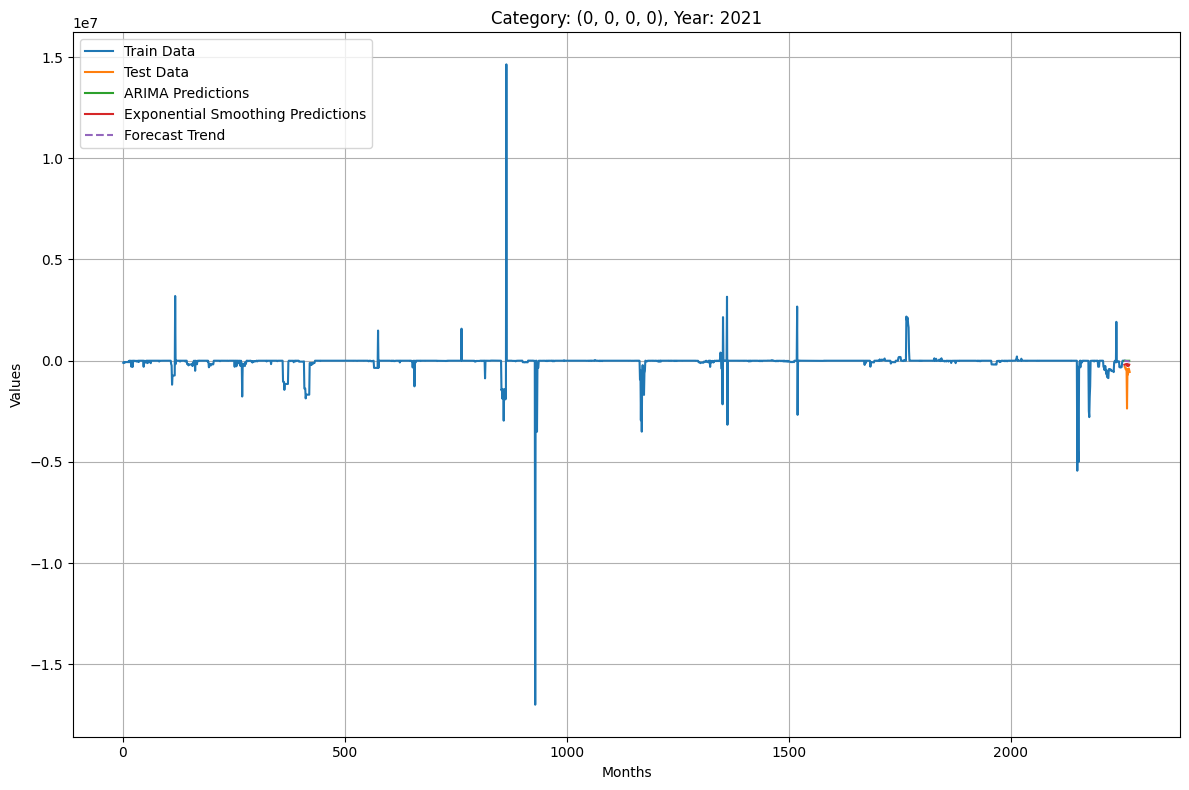

Category: (0, 0, 0, 1), Year: 2019 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


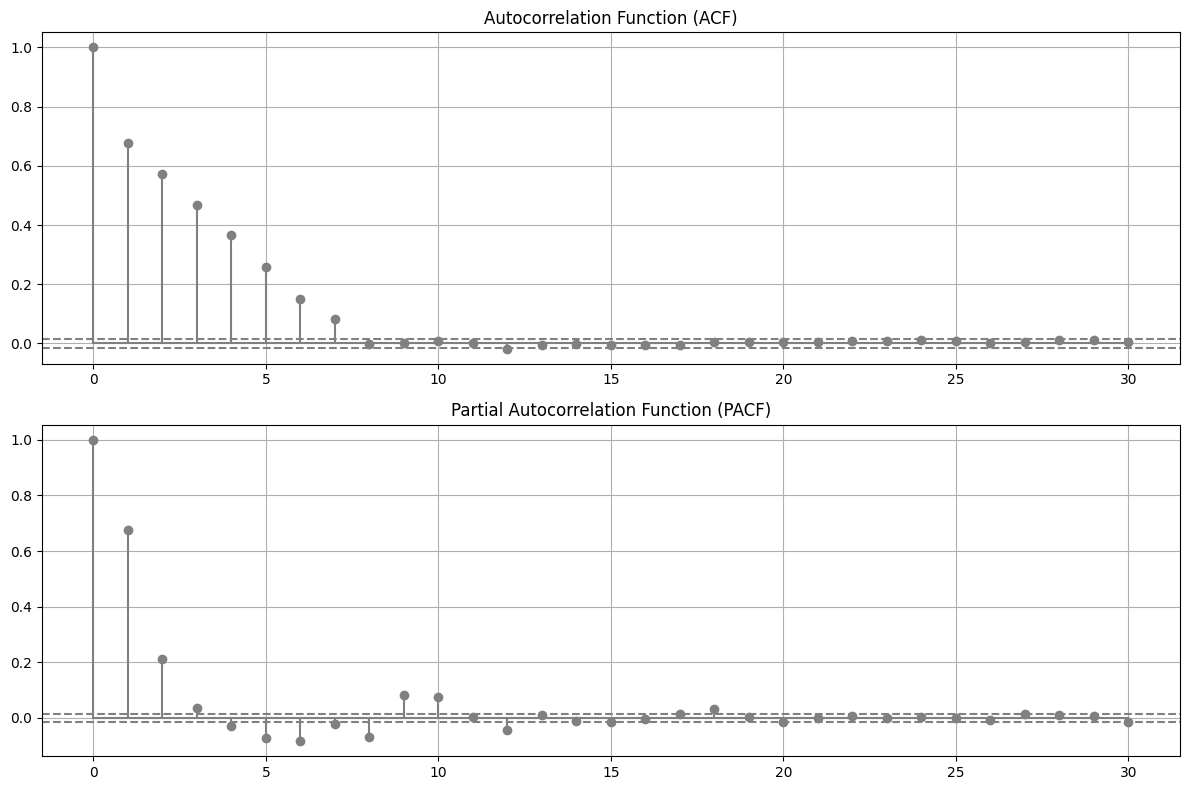

ARIMA - MSE: 250643.7955269326 RMSE: 500.643381587066 MAPE: 75.73104695534697
Exponential Smoothing - MSE: 1050759513.0518727 RMSE: 32415.420914309794 MAPE: 10390.37950724159
SARIMA - MSE: 575585275.6873783 RMSE: 23991.35835436123 MAPE: 2219.44071386797


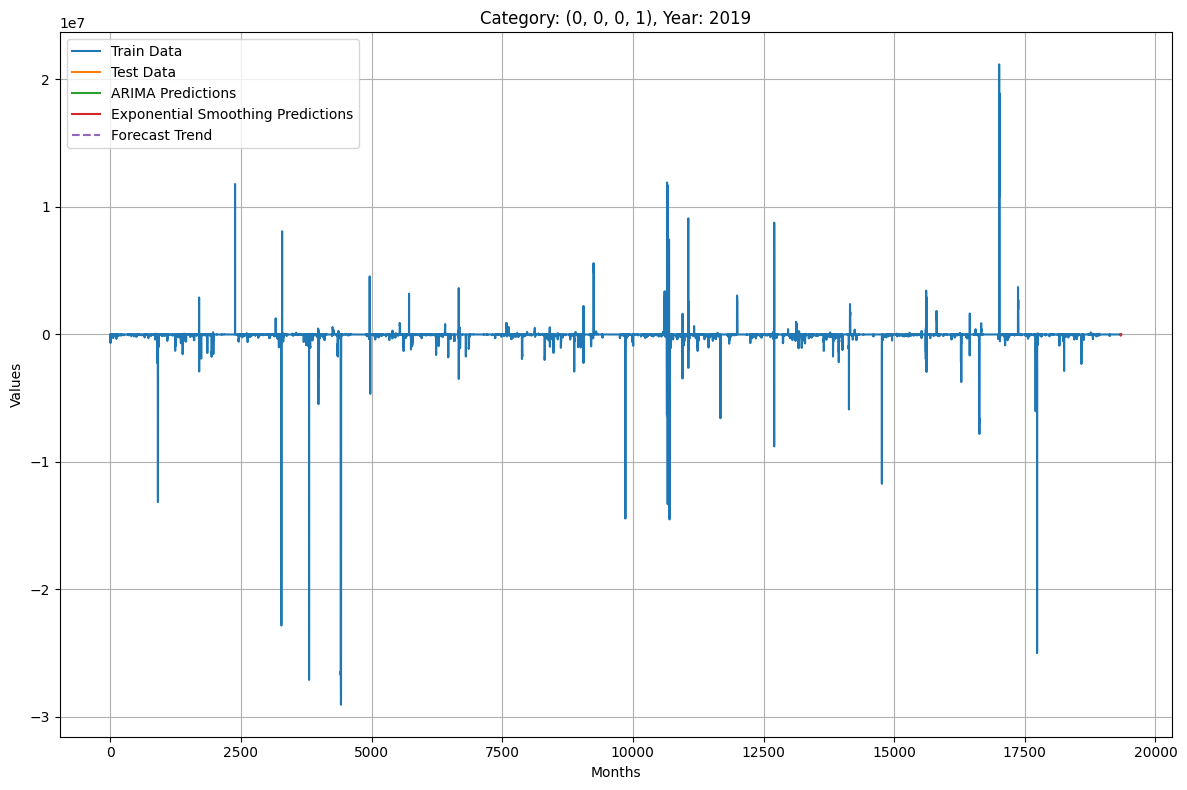

Category: (0, 0, 0, 1), Year: 2020 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


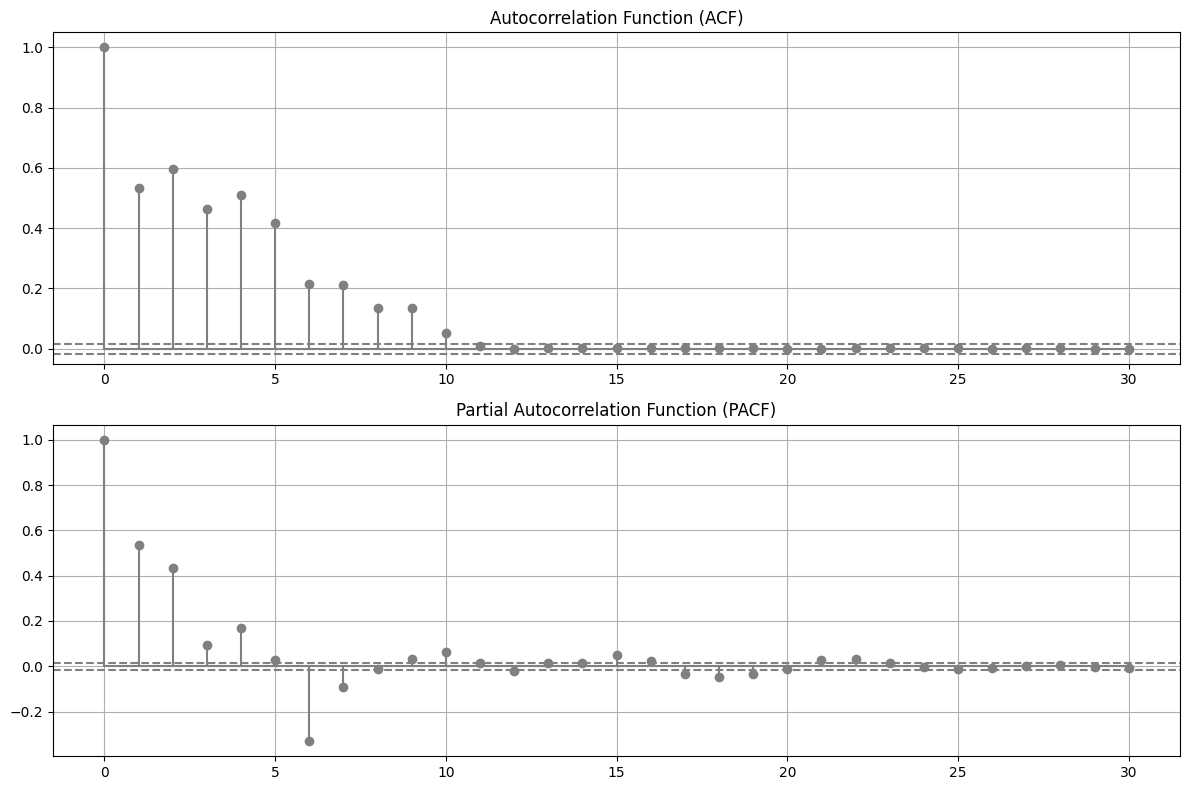

ARIMA - MSE: 6062582.340411748 RMSE: 2462.231171196512 MAPE: 1.5133017283571182
Exponential Smoothing - MSE: 1341121851.614998 RMSE: 36621.33055495114 MAPE: 777.3478232379159
SARIMA - MSE: 536113826931.197 RMSE: 732197.9424521739 MAPE: 23661.255530706


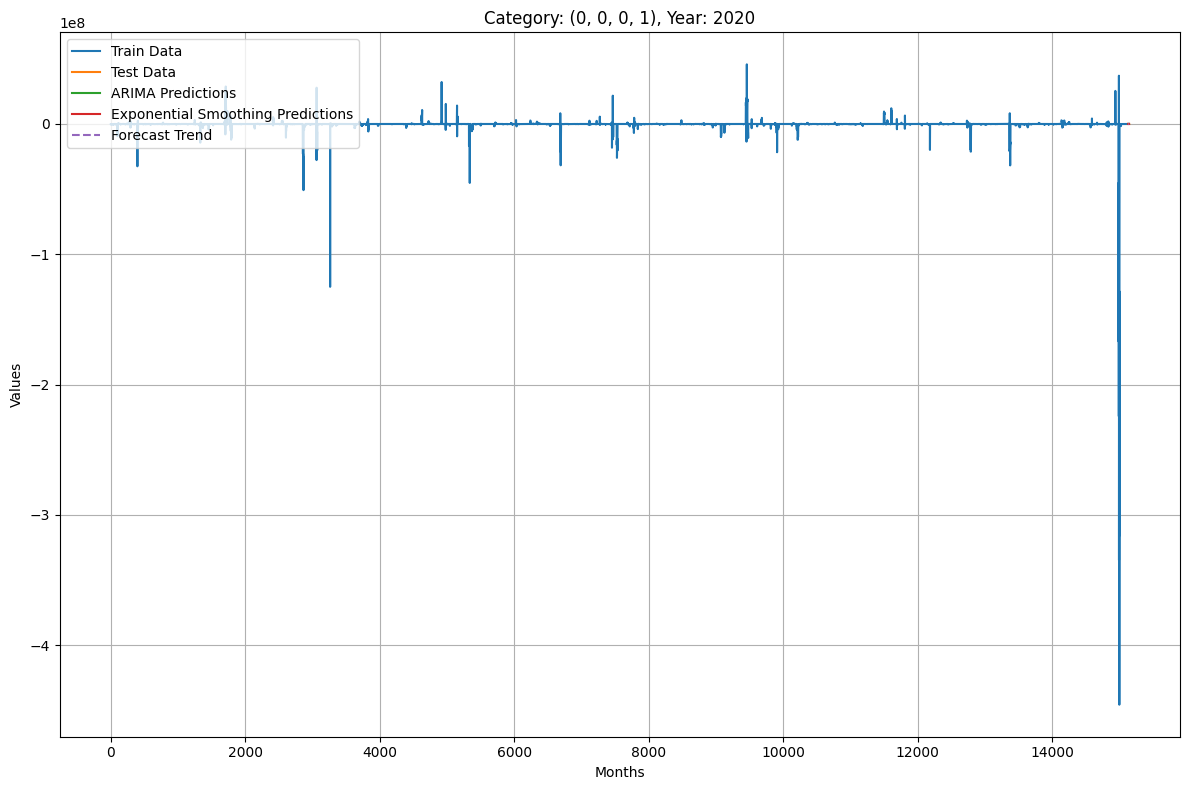

Category: (0, 0, 0, 1), Year: 2021 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


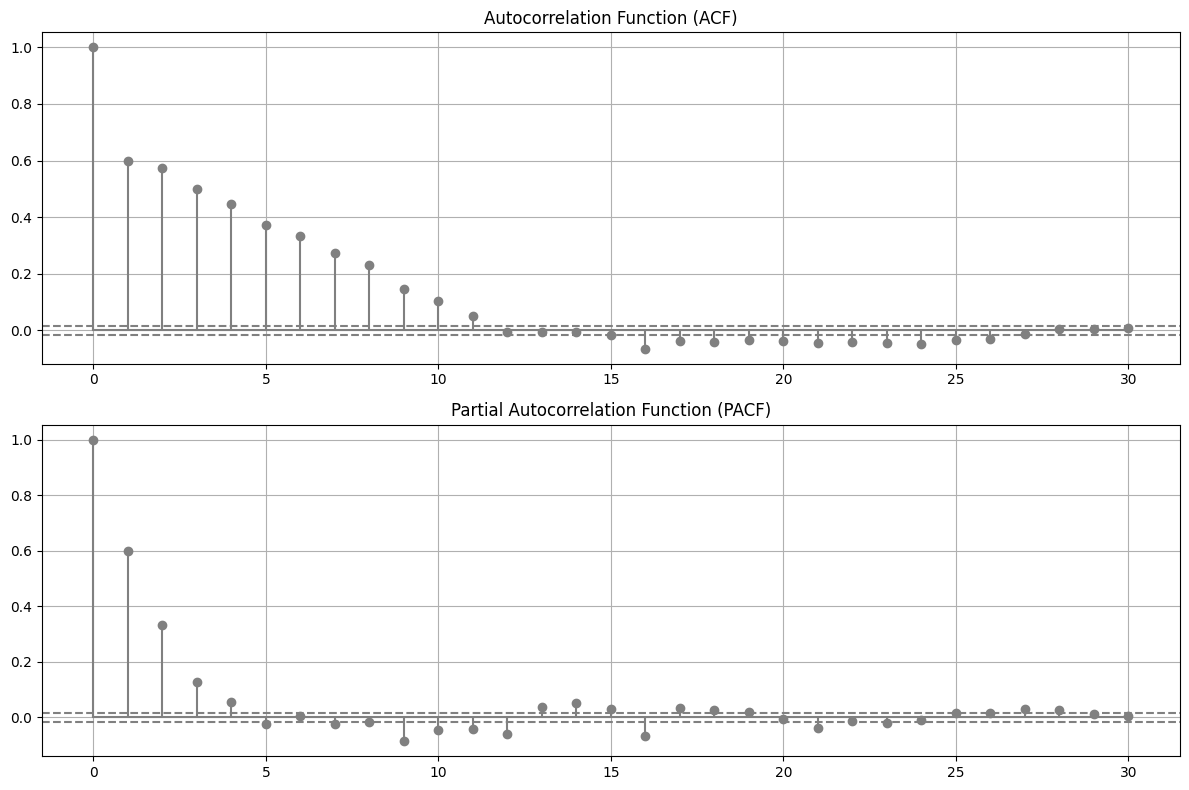

ARIMA - MSE: 318789913891166.0 RMSE: 17854688.848903697 MAPE: 99.86061819667894
Exponential Smoothing - MSE: 314639379137701.7 RMSE: 17738077.098087654 MAPE: 99.19912448801776
SARIMA - MSE: 316898071673557.3 RMSE: 17801631.15204776 MAPE: 99.56017375893525


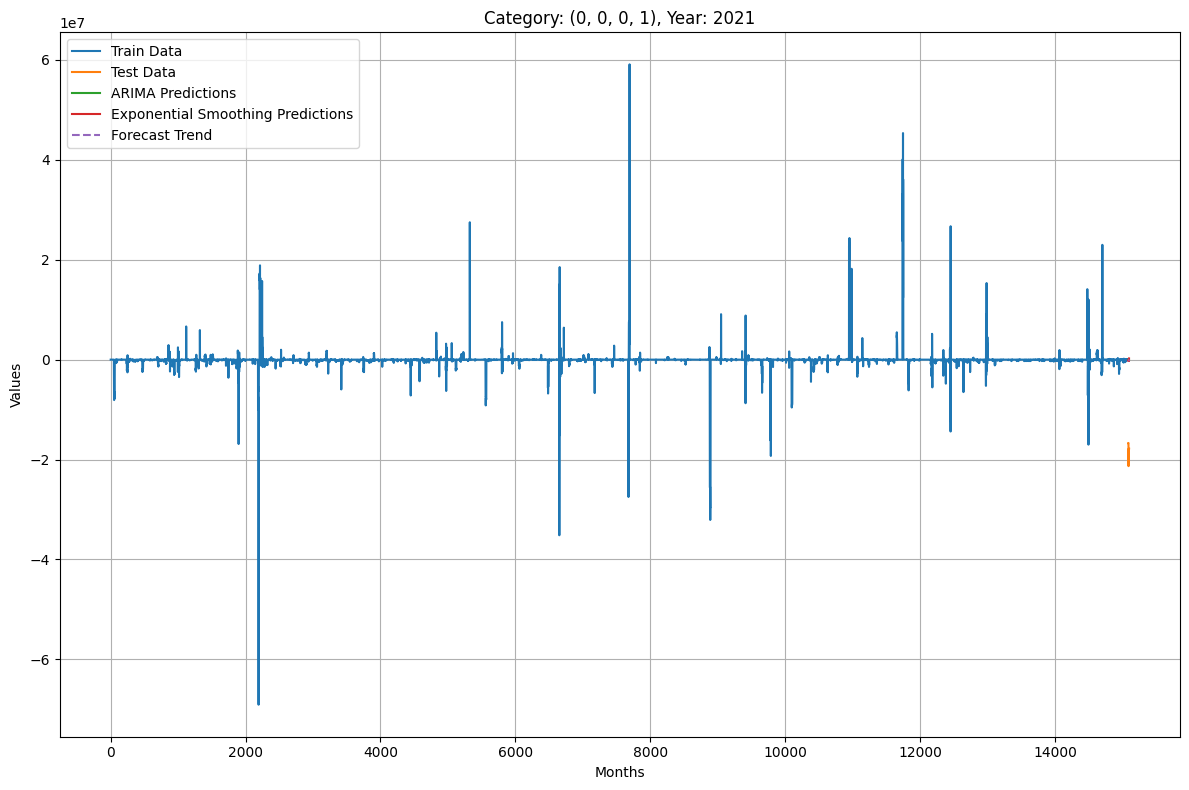

Category: (0, 0, 1, 0), Year: 2019 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


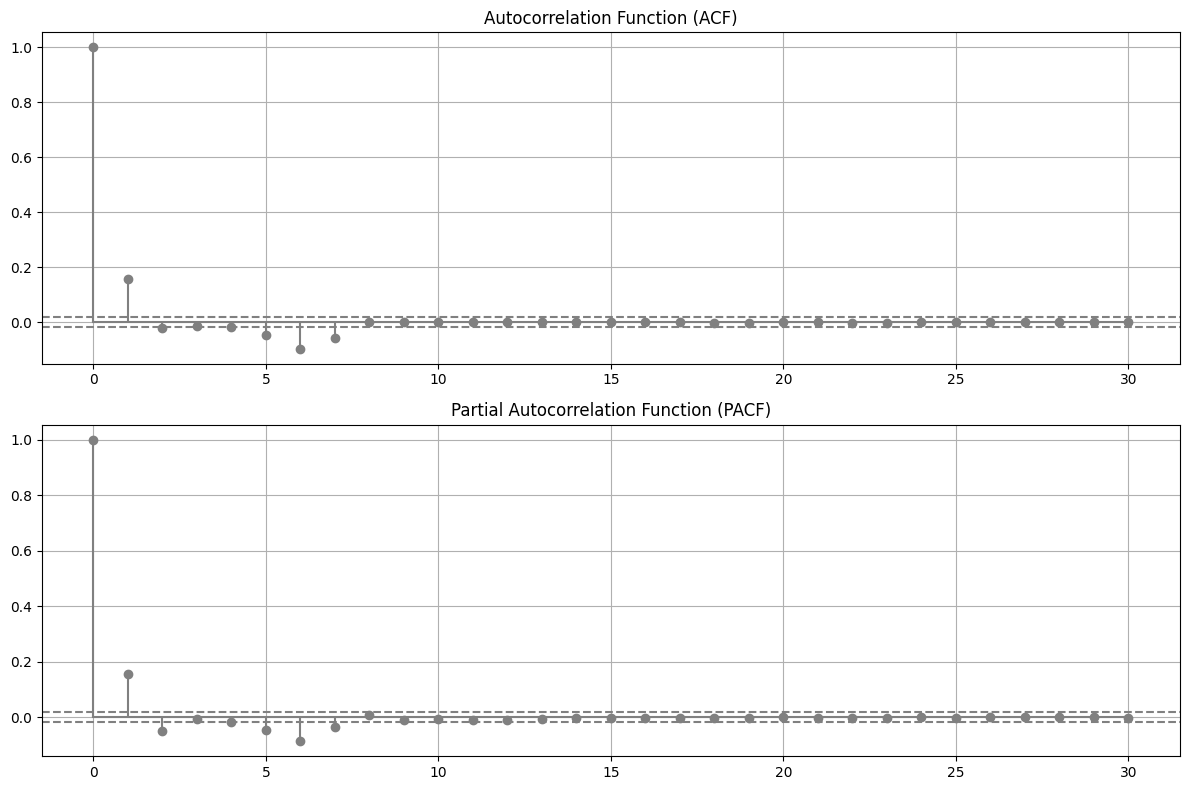

ARIMA - MSE: 160088.1932590384 RMSE: 400.1102263864777 MAPE: 24.207115950584257
Exponential Smoothing - MSE: 35137313653.32937 RMSE: 187449.4962738747 MAPE: 33335.31184366865
SARIMA - MSE: 4337070634597.158 RMSE: 2082563.476726978 MAPE: 335376.6641317639


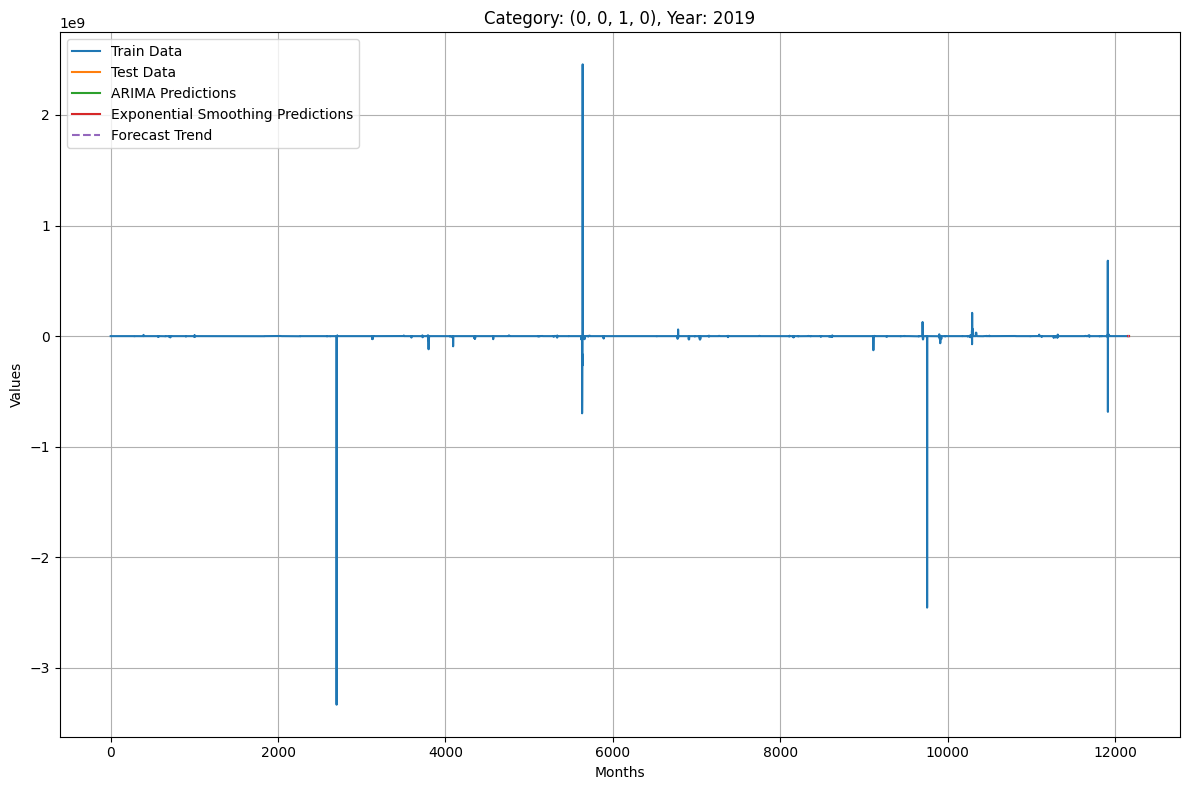

Category: (0, 0, 1, 0), Year: 2020 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


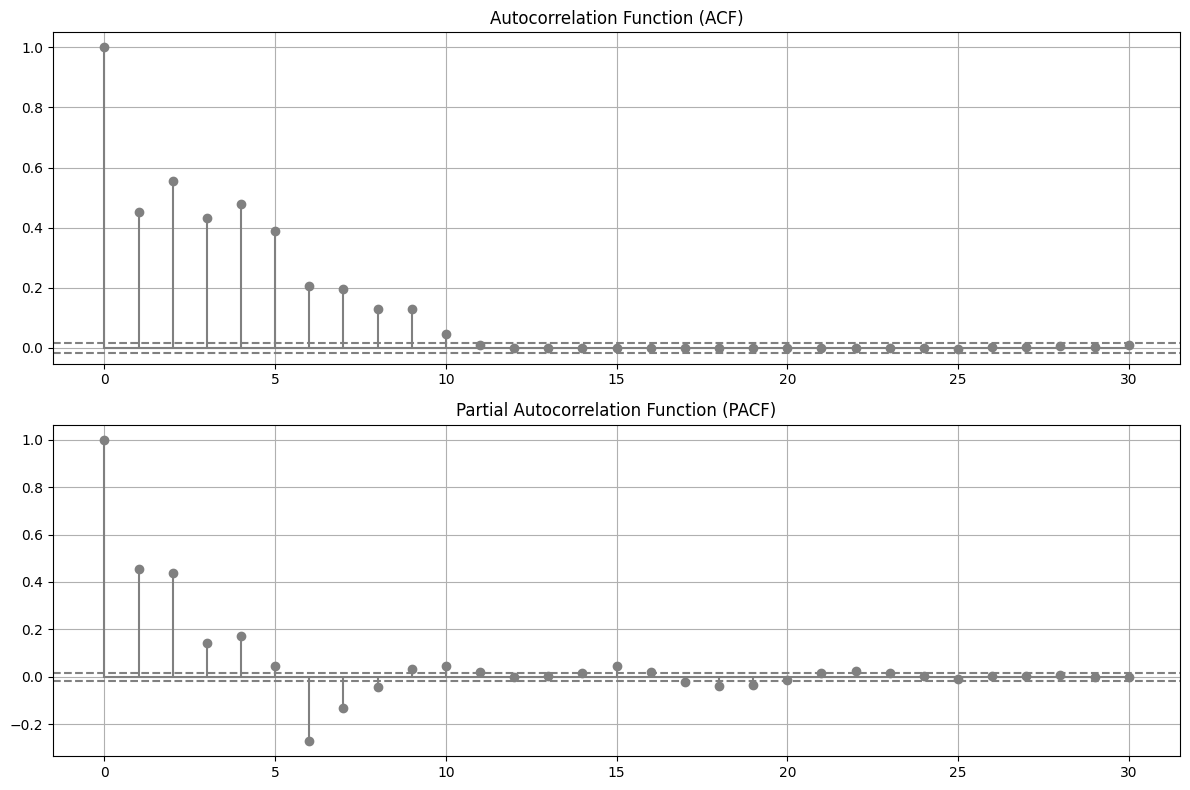

ARIMA - MSE: 212945.2948382243 RMSE: 461.4599601679698 MAPE: 100.0
Exponential Smoothing - MSE: 36889673080.601746 RMSE: 192066.84534453557 MAPE: 3746.371614958604
SARIMA - MSE: 101839027241.16158 RMSE: 319122.2763160879 MAPE: 29836.356484035787


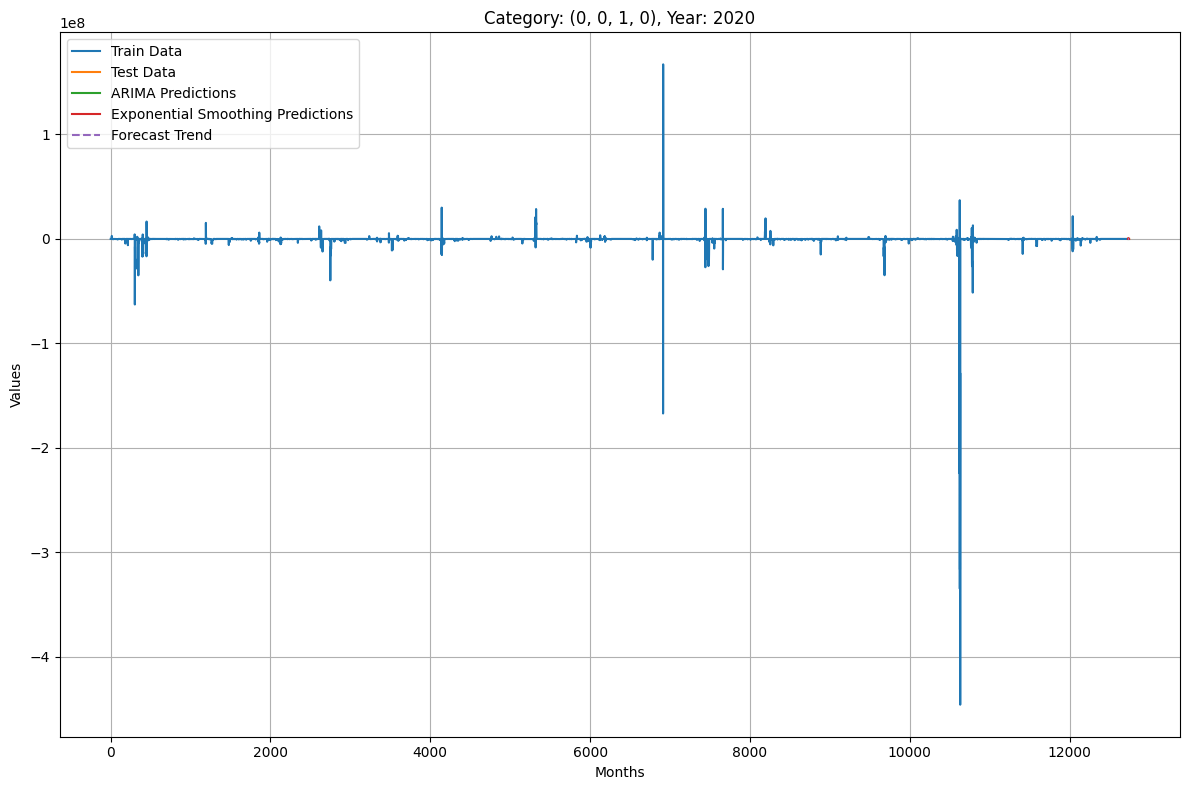

Category: (0, 0, 1, 0), Year: 2021 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parame

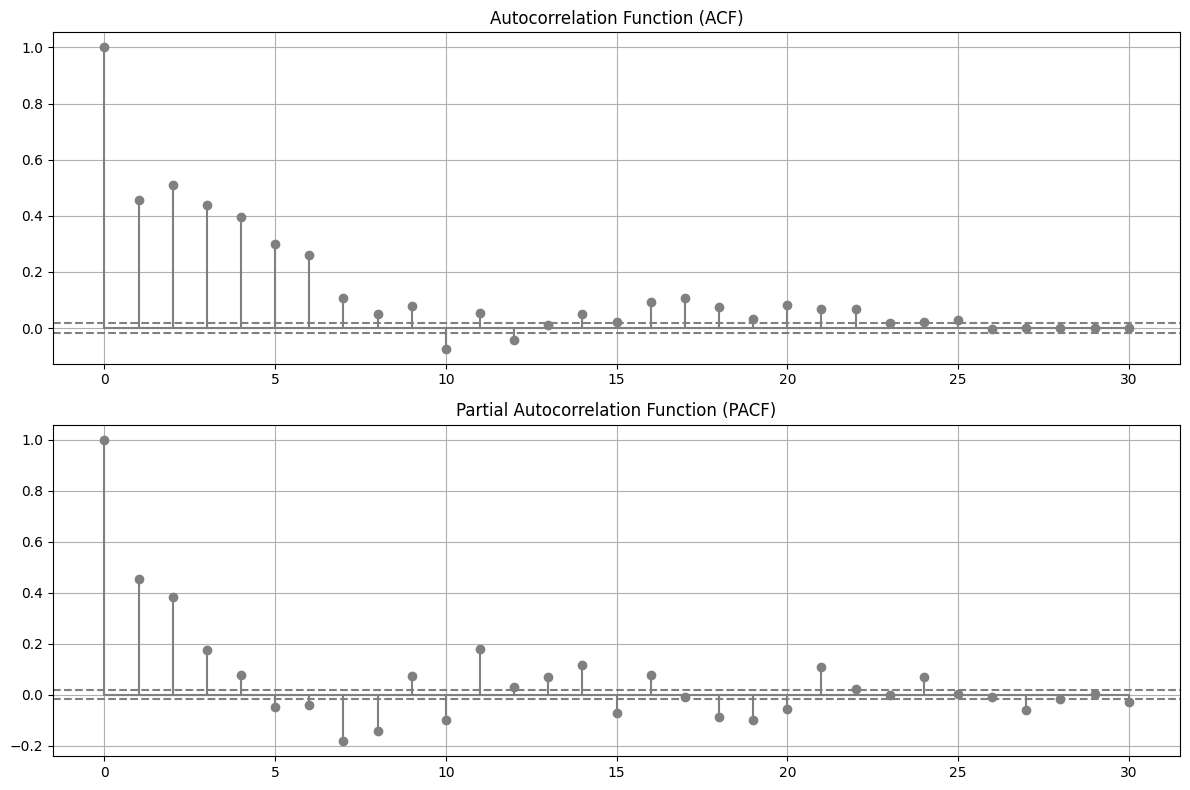

ARIMA - MSE: 2.7545779094411604e+16 RMSE: 165969211.28453797 MAPE: 19367561.033905424
Exponential Smoothing - MSE: 3.0937643920613044e+16 RMSE: 175891000.1126068 MAPE: 20582558.76154352
SARIMA - MSE: 2.7676474092884604e+16 RMSE: 166362478.01978847 MAPE: 19427657.619722117


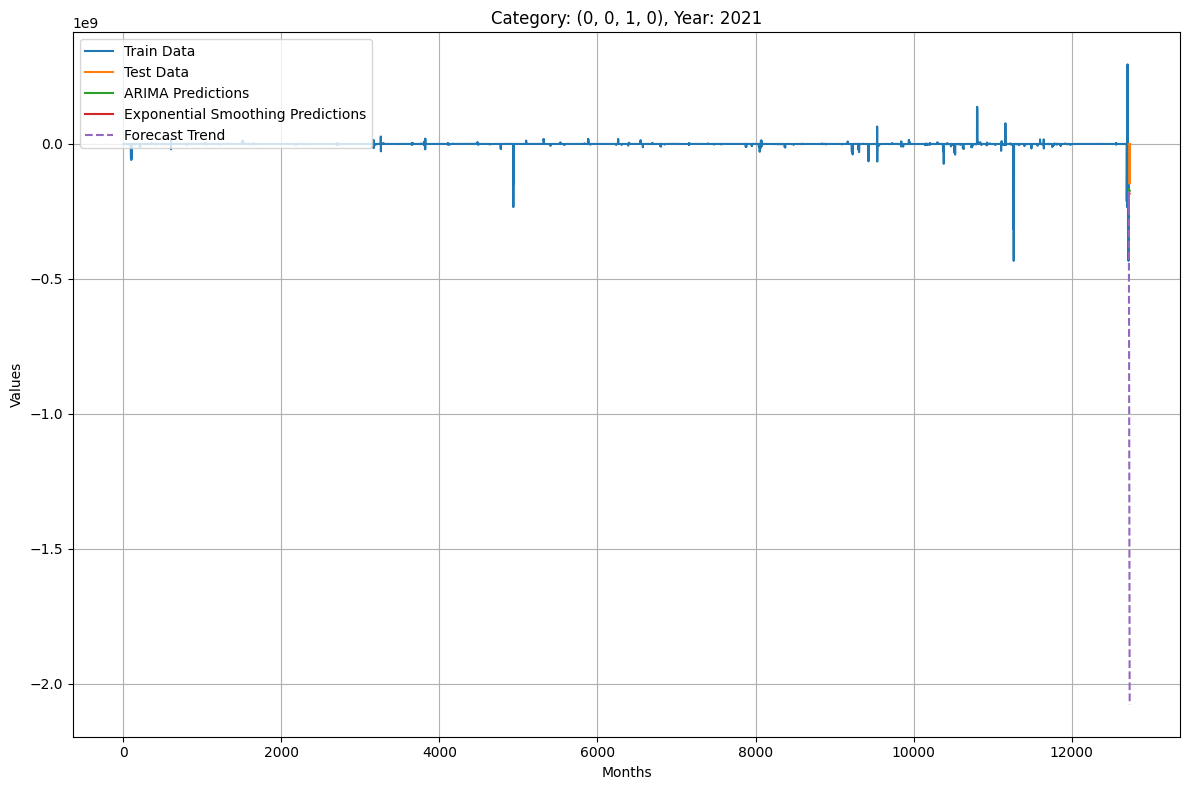

Category: (0, 1, 0, 0), Year: 2019 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


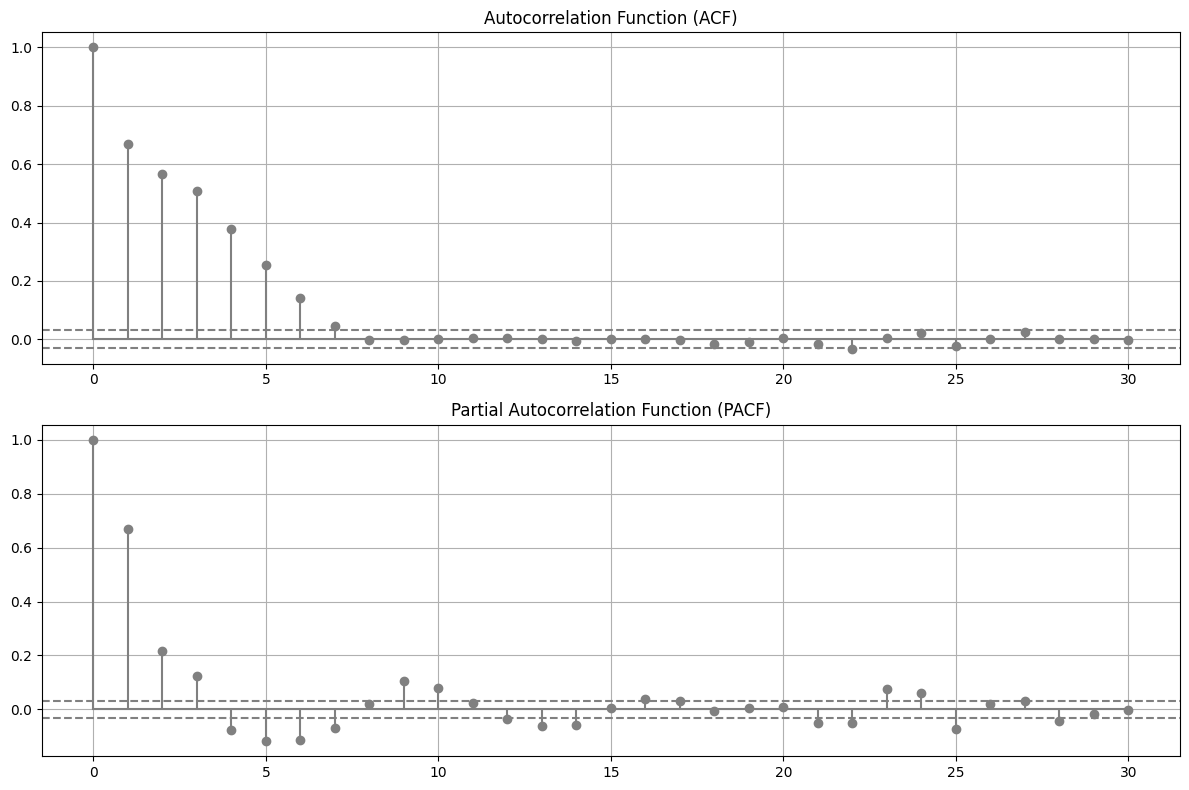

ARIMA - MSE: 105857.64955835867 RMSE: 325.35772552431985 MAPE: 42.26618657443041
Exponential Smoothing - MSE: 439559947314.434 RMSE: 662993.1729018287 MAPE: 77727.73346096642
SARIMA - MSE: 38414371562.68878 RMSE: 195995.8457791613 MAPE: 21812.49444973241


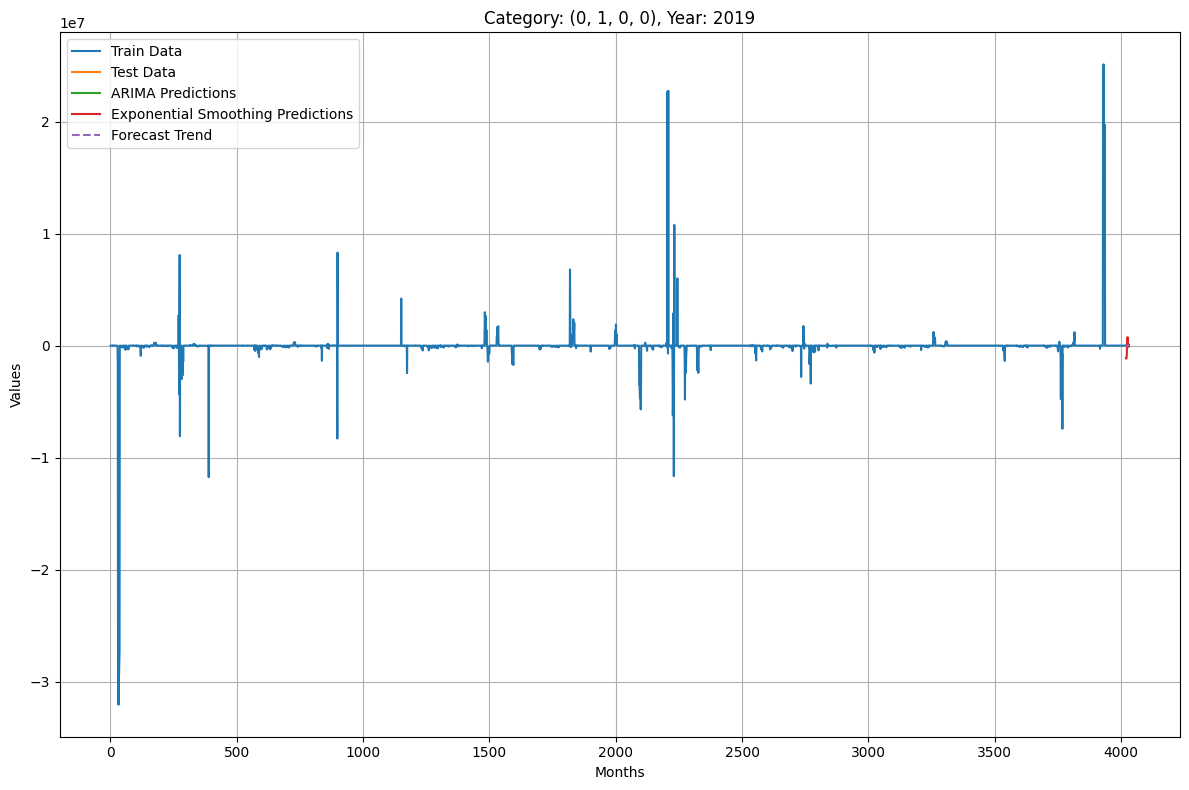

Category: (0, 1, 0, 0), Year: 2020 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


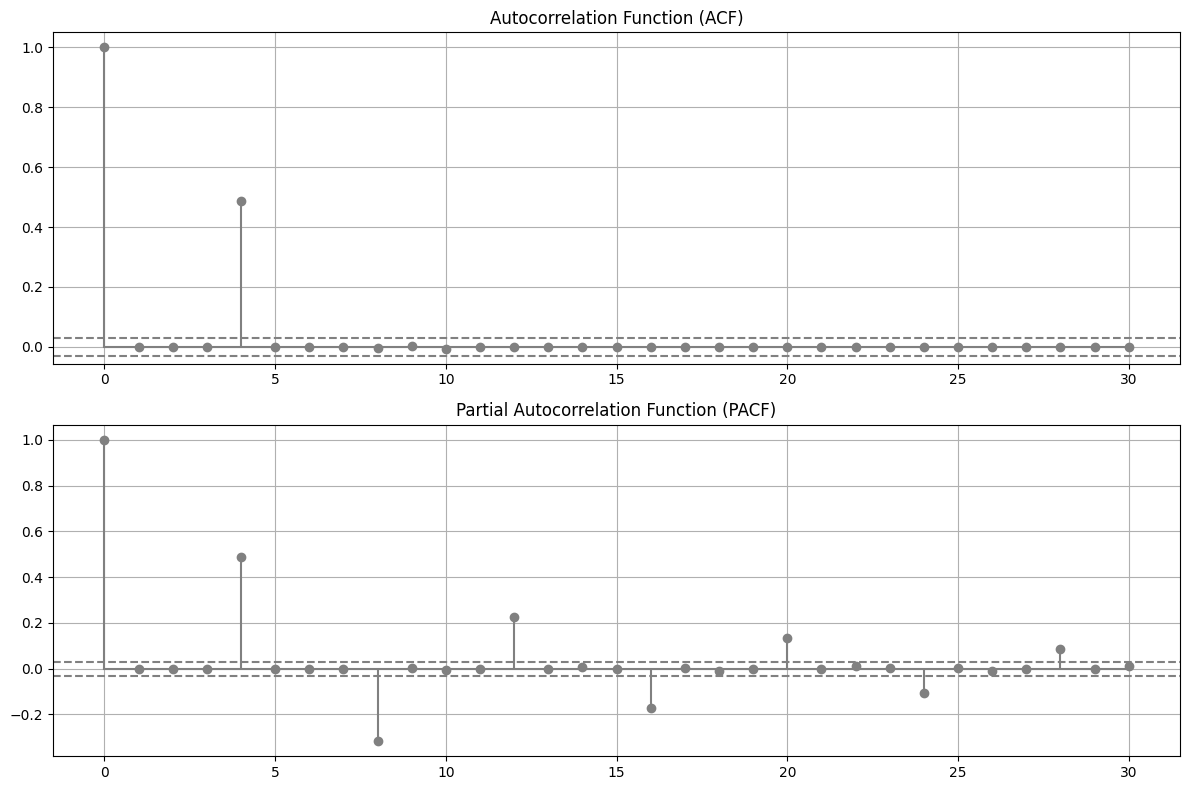

ARIMA - MSE: 70665.36915940359 RMSE: 265.8295866892991 MAPE: 83.58212062941837
Exponential Smoothing - MSE: 3678891269207.0566 RMSE: 1918043.6046156657 MAPE: 229507.14958502643
SARIMA - MSE: 6720013732554.917 RMSE: 2592298.928085825 MAPE: 730113.125445959


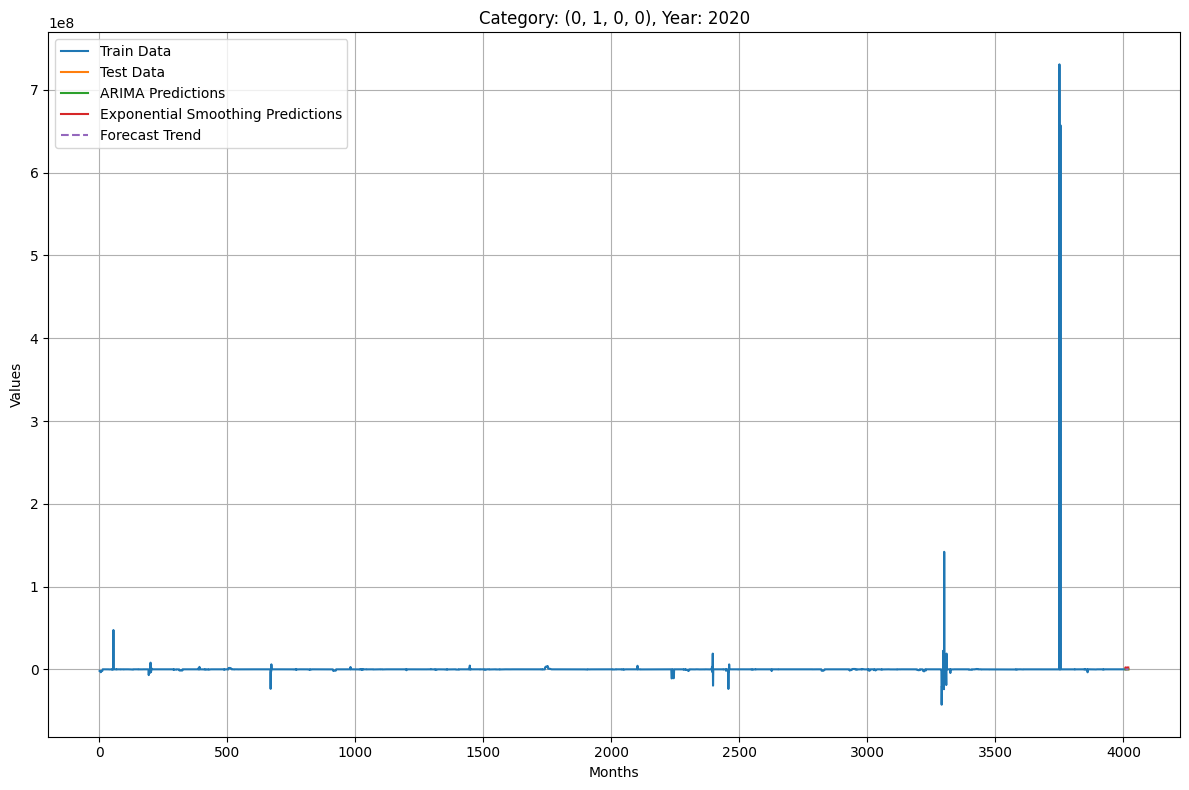

Category: (0, 1, 0, 0), Year: 2021 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


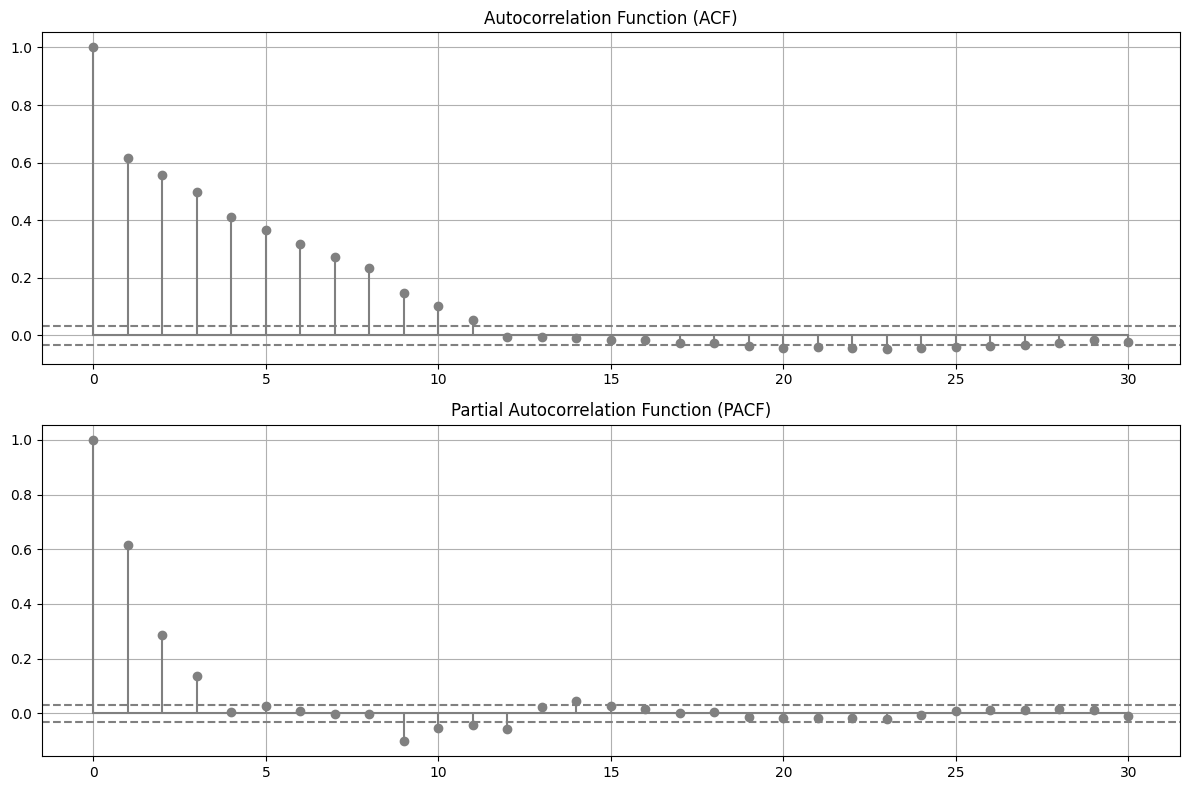

ARIMA - MSE: 5862997.178477013 RMSE: 2421.362669753751 MAPE: 100.0
Exponential Smoothing - MSE: 179666452.75920156 RMSE: 13403.97152933419 MAPE: 387.01407201818785
SARIMA - MSE: 542455628.6834884 RMSE: 23290.676861858017 MAPE: 782.1870357587926


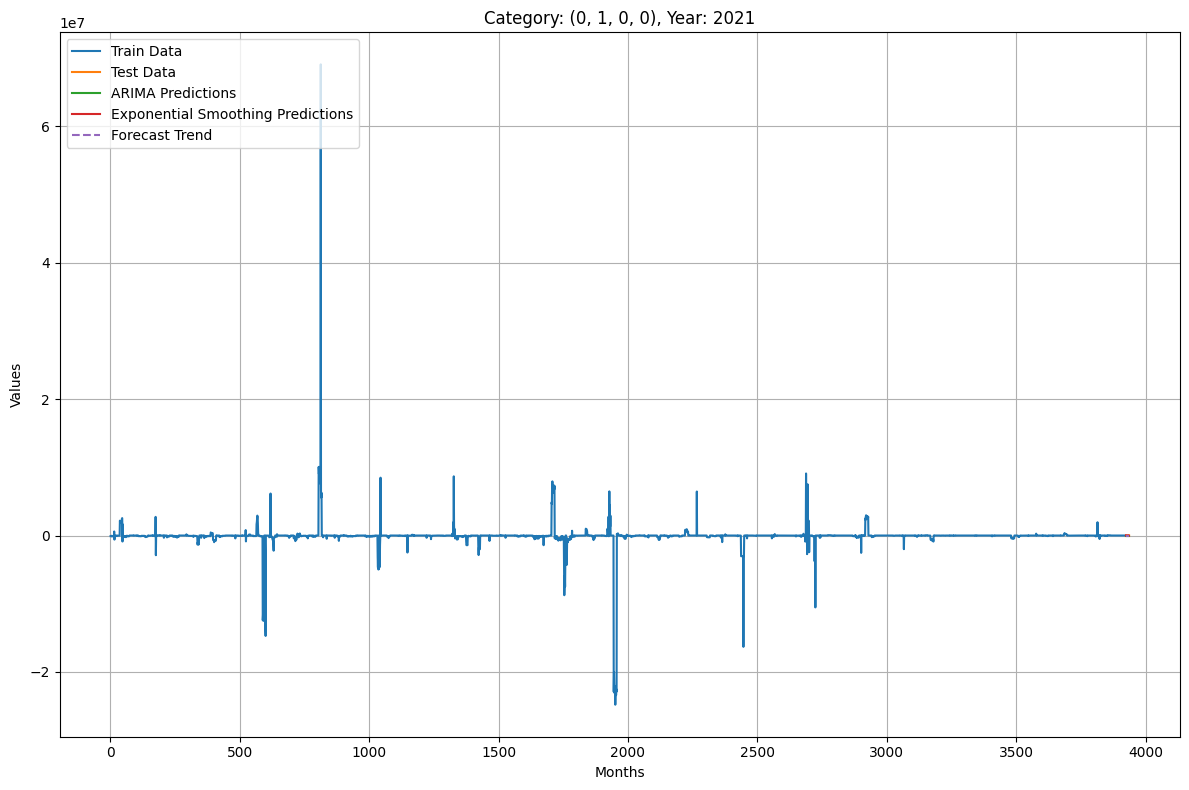

Category: (1, 0, 0, 0), Year: 2019 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


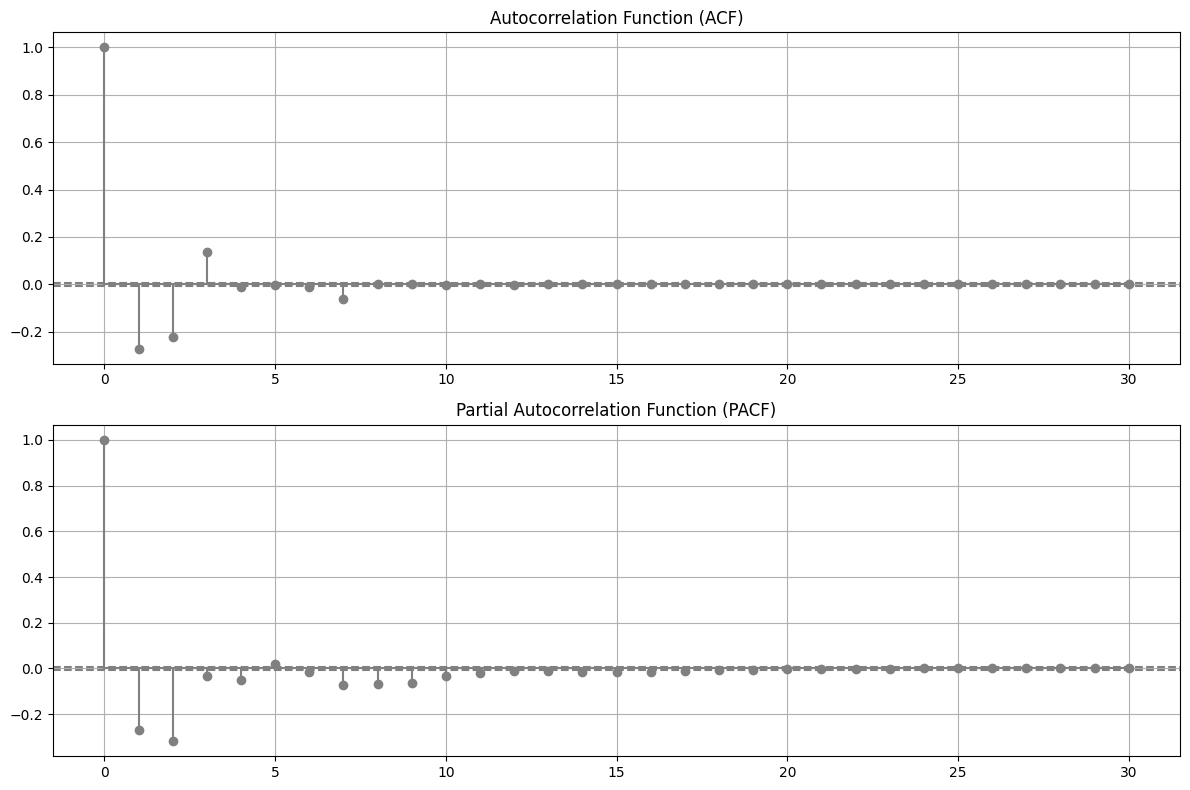

ARIMA - MSE: 183850.60329633323 RMSE: 428.77803499751855 MAPE: 11.945659131893523
Exponential Smoothing - MSE: 28145505655.63782 RMSE: 167766.2232263629 MAPE: 122.61275592848433
SARIMA - MSE: 2268742402.2449756 RMSE: 47631.31745233356 MAPE: 19787.74554229187


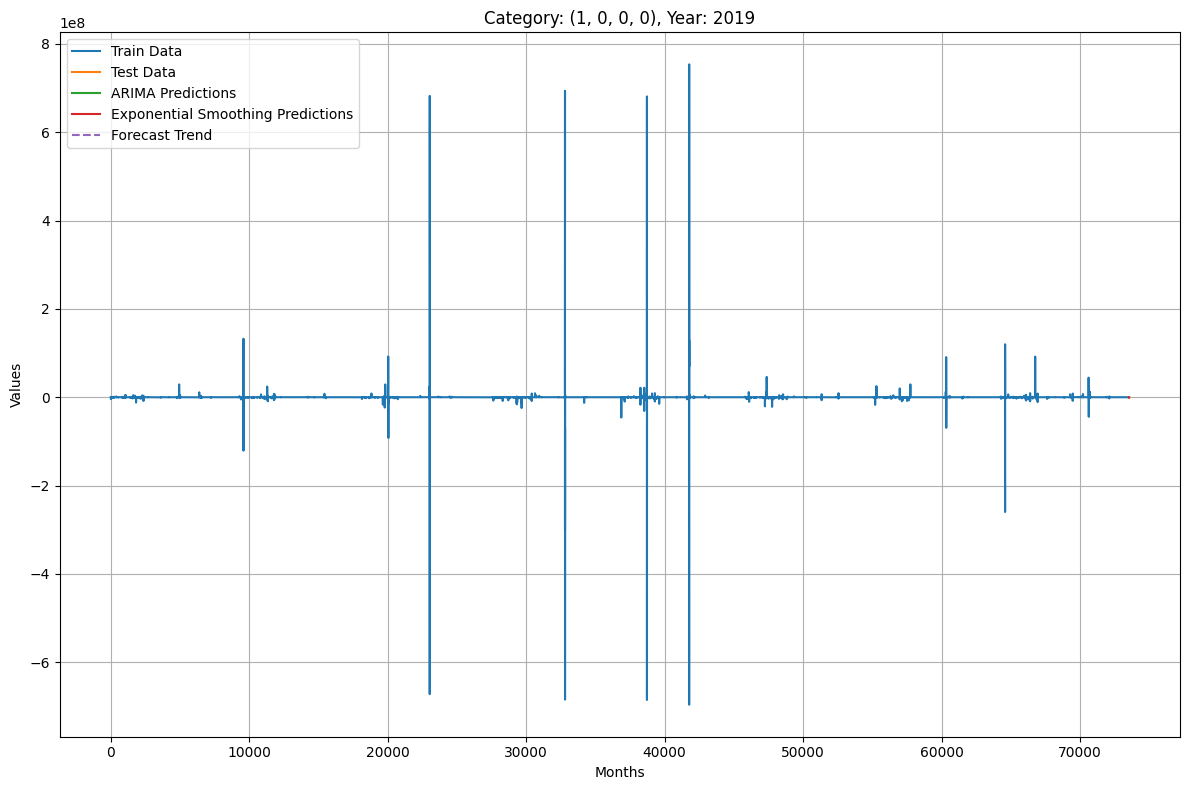

Category: (1, 0, 0, 0), Year: 2020 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-2-c378cc2923a7>:172: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)
<ipython-input-2-c378cc2923a7>:179: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(pacf_values, markerfmt='o', linefmt='gray', basefmt='gray', use_line_collection=True)


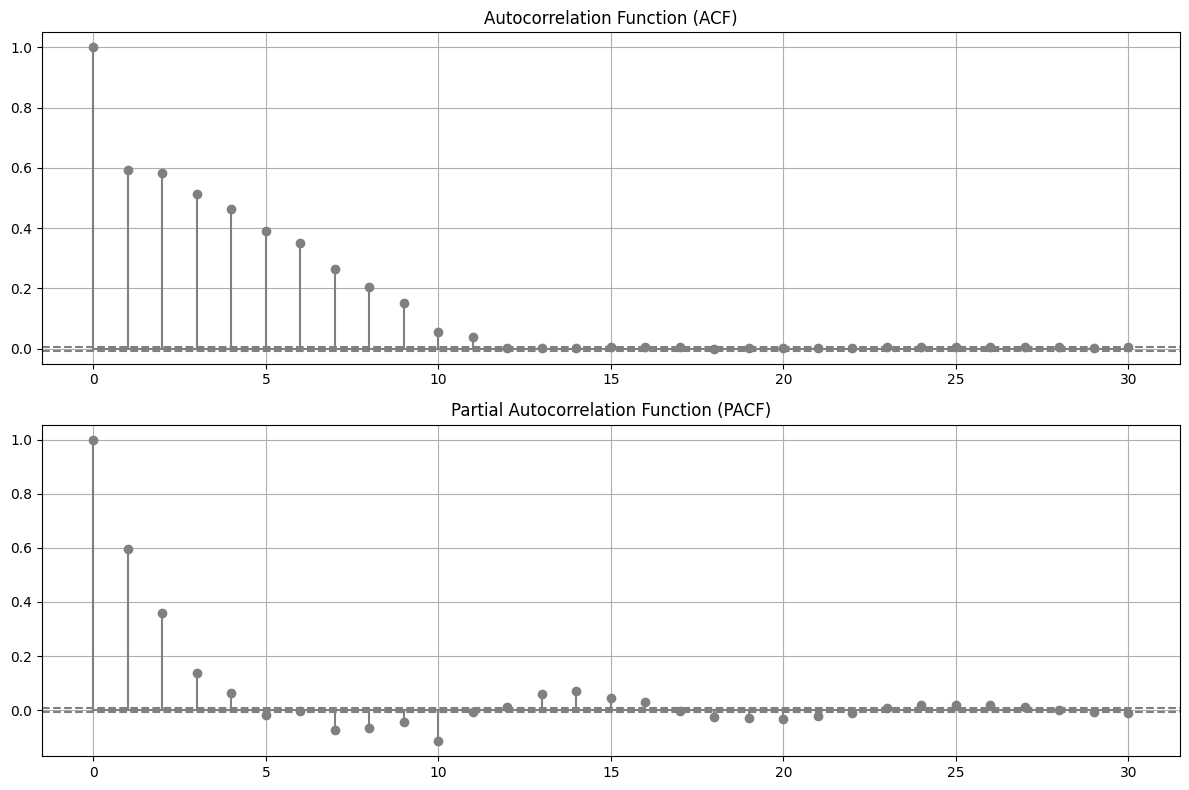

ARIMA - MSE: 25957.206573842526 RMSE: 161.11240353815882 MAPE: 94.52191983879995
Exponential Smoothing - MSE: 19744814.130387846 RMSE: 4443.513714436791 MAPE: 898.6667163495292
SARIMA - MSE: 308326207.63178235 RMSE: 17559.220017750857 MAPE: 941.9304965431526


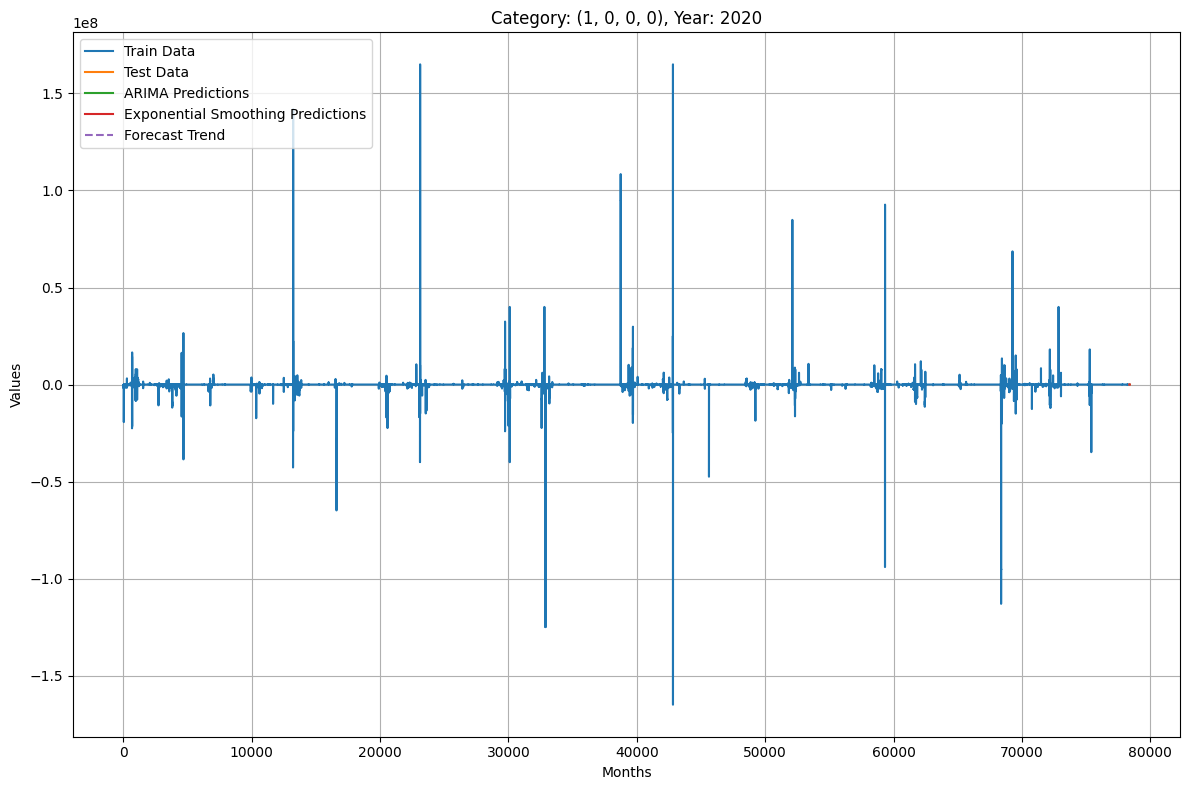

Category: (1, 0, 0, 0), Year: 2021 - Time series is Stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
